In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from copy import deepcopy

trainset = datasets.MNIST(root='./data',
                          download=False,
                          train=True,
                          transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data',
                          download=False,
                          train=False,
                          transform=transforms.ToTensor())

# HYPERPARAMETERS
BATCH = 256
LR = 0.001
CLASSES = 10
FEATURES = 28 * 28
REDUCE_TO = 2
HIDDEN = 100
EPOCHS = 20

trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH, shuffle=False)

class AutoEncoder(nn.Module):
    def __init__(self, latent_dim: int = REDUCE_TO,
                 in_feats: int = FEATURES,
                 hidden_neurons: int = HIDDEN):
        super().__init__()
        self.encode = nn.Sequential(
            nn.BatchNorm1d(in_feats),
            nn.Linear(in_feats, hidden_neurons),
            nn.ReLU(),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.ReLU(),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.ReLU(),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.ReLU(),
            nn.Linear(hidden_neurons, latent_dim),
            nn.BatchNorm1d(2)
        )
        self.decode = nn.Sequential(
            nn.Linear(latent_dim, hidden_neurons),
            nn.ReLU(),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.ReLU(),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.ReLU(),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.ReLU(),
            nn.Linear(hidden_neurons, in_feats)
        )

    def forward(self, x):
        return self.decode(self.encode(x))

def train_AE(model: nn.Module,
             epochs: int = EPOCHS,
             trainloader: DataLoader = trainloader):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        running_loss = 0
        for i, (input, _) in enumerate(trainloader):
            # Forward pass
            input = input.view(input.size(0), -1)
            pred = model(input)
            loss = criterion(pred, input)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print(f'Epoch: {epoch}, Train Loss: {running_loss}')
    print('Finished Training.')

def test_AE(model: nn.Module,
            testloader: DataLoader = testloader,
            to_print: bool = True):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.
    for (input, _) in testloader:
        input = input.view(input.size(0), -1)
        pred = model(input)
        loss = criterion(input, pred)
        total_loss += loss.item()
    if to_print:
        print(f'Test Loss: {total_loss}.')
    return total_loss

def visualize_latent(model: nn.Module, loader: DataLoader = testloader):
    latent_space = []
    labels = []
    for (input, label) in loader:
        input = input.view(input.size(0), -1)
        output = model.encode(input)
        latent_space.append(output.detach().numpy())
        labels.append(label.detach().numpy())
    latent_space = np.concatenate(latent_space, axis = 0)
    labels = np.concatenate(labels, axis = 0)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(latent_space[:, 0], latent_space[:, 1],
               c = labels, cmap='tab10', alpha=0.3)
    ax.legend()

def project_represent(model: nn.Module,
                      loader: DataLoader,
                      anchors: torch.tensor,
                      sim_type: str = 'cos'):
    anchors_encoded = model(anchors.view(anchors.size(0), -1))
    anchors_norm = anchors_encoded / anchors_encoded.norm(dim=1, keepdim=True)
    similarities = []
    if sim_type == 'cos':
        for (batch, _) in loader:
            batch_encoded = model(batch.view(batch.size(0), -1))
            batch_normal = batch_encoded / batch_encoded.norm(dim=1, keepdim=True)
            batch_sim = batch_normal @ anchors_norm.T
            similarities.append(batch_sim)
        sim_mat = torch.cat(similarities, dim=0)
    return sim_mat

def visualize_reconst(model: nn.Module,
                      data: Dataset,
                      idx: int):
    plt.imshow(model(torch.tensor(data.data[idx].detach().numpy().reshape(1, 784),
                          dtype=torch.float32)).detach().numpy().reshape(28, 28), cmap='gray')
    
def encode(model: nn.Module,
           dataloader: DataLoader = trainloader):
    out = []
    for (input, _) in dataloader:
        input = input.view(input.size(0), -1)
        pred = model.encode(input)
        out.append(pred)
    input = torch.cat(input, dim=0)
    return input

In [261]:
indices = np.array([10, 14, 1, 30, 27, 23, 21, 0, 84, 9])
anchor_count = indices.shape[0]
anchors = testset.data[indices].type(torch.float32)
reps = project_represent(M, testloader, anchors)

trials = 0
results = np.zeros((trials, 10000, anchor_count))
accs = np.zeros(trials)
for t in range(trials):
    M = AutoEncoder()
    train_AE(M, 10)
    accs[t] = test_AE(M, to_print=False)
    results[t, :, :] = project_represent(M, testloader, anchors).detach().numpy()

Epoch: 0, Train Loss: 13.712015390396118
Epoch: 1, Train Loss: 11.316158641129732
Epoch: 2, Train Loss: 10.68810722231865
Epoch: 3, Train Loss: 10.35068690776825
Epoch: 4, Train Loss: 10.19745734333992
Epoch: 5, Train Loss: 10.058461870998144
Epoch: 6, Train Loss: 9.897604040801525
Epoch: 7, Train Loss: 9.77829771488905
Finished Training.
Epoch: 0, Train Loss: 13.690418232232332
Epoch: 1, Train Loss: 11.205607317388058
Epoch: 2, Train Loss: 10.707886818796396
Epoch: 3, Train Loss: 10.377649769186974
Epoch: 4, Train Loss: 10.12965278327465
Epoch: 5, Train Loss: 10.015880089253187
Epoch: 6, Train Loss: 9.90125810727477
Epoch: 7, Train Loss: 9.844871006906033
Finished Training.
Epoch: 0, Train Loss: 13.813316009938717
Epoch: 1, Train Loss: 11.371230266988277
Epoch: 2, Train Loss: 10.860937990248203
Epoch: 3, Train Loss: 10.570771768689156
Epoch: 4, Train Loss: 10.3609071187675
Epoch: 5, Train Loss: 10.167681232094765
Epoch: 6, Train Loss: 9.978467129170895
Epoch: 7, Train Loss: 9.85128248

In [2]:
# PCA on large anchor set
%pip install scikit-learn
from sklearn.decomposition import PCA

SIZE = 100

indices = np.random.choice(np.arange(len(testset)), 100, replace=False)
anchor_count = len(indices)
anchors = testset.data[indices]

trials = 3
rel_results = np.zeros((trials, 10000, anchor_count))
rel_pca_results = np.zeros((trials, 10000, 2))
abs_results = np.zeros((trials, 10000, 2))

for t in range(trials):
    M = AutoEncoder()
    train_AE(M, 8)
    accs[t] = test_AE(M, to_print=False)
    rel_results[t, :, :] = project_represent(M, testloader, anchors).detach().numpy()
    pca = PCA(n_components=2)
    pca.fit_transform(rel_results[t, :, :])
    rel_pca_results[t, :, :] = pca.fit_transform(rel_results[t, :, :])
    abs_results[t, :, :] = encode(M, testloader).detach().numpy()
    

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 4.8 MB/s eta 0:00:00a 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 5.0 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


ImportError: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.

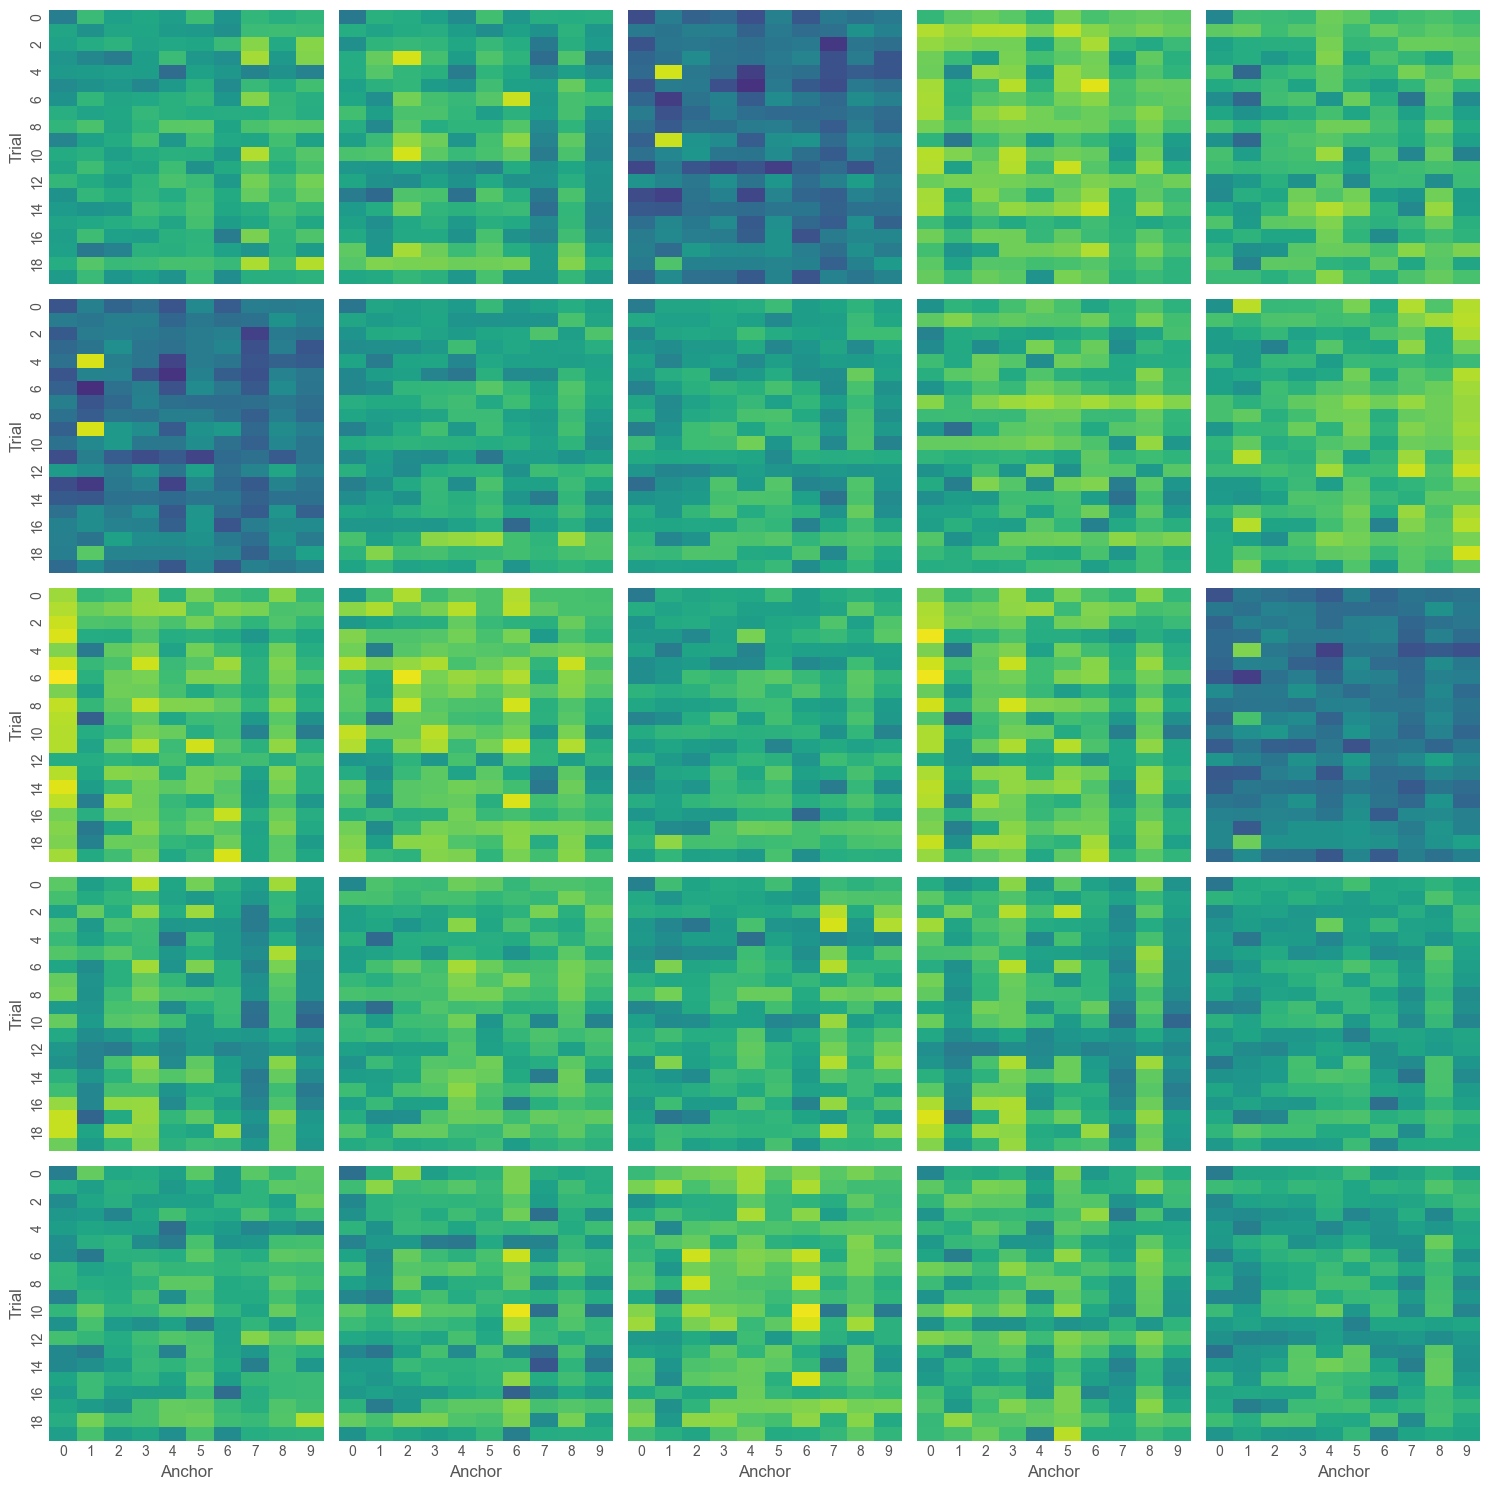

In [263]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
axs = axs.flatten()
cmap = 'viridis'
vmin, vmax = 0.0, 1.0
for i, ax in enumerate(axs):      
    hmap_array = results[:, i, :]  
    seaborn.heatmap(hmap_array, ax=ax, cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)

    if i >= 20:
        ax.set_xlabel('Anchor')
    else:
        ax.set_xticklabels([])

    if i % 5 == 0:
        ax.set_ylabel('Trial')
    else:
        ax.set_yticklabels([])

plt.tight_layout()

/var/folders/nm/67sg27fj44j1q38vxt0_vzv80000gq/T/ipykernel_66096/4184314533.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


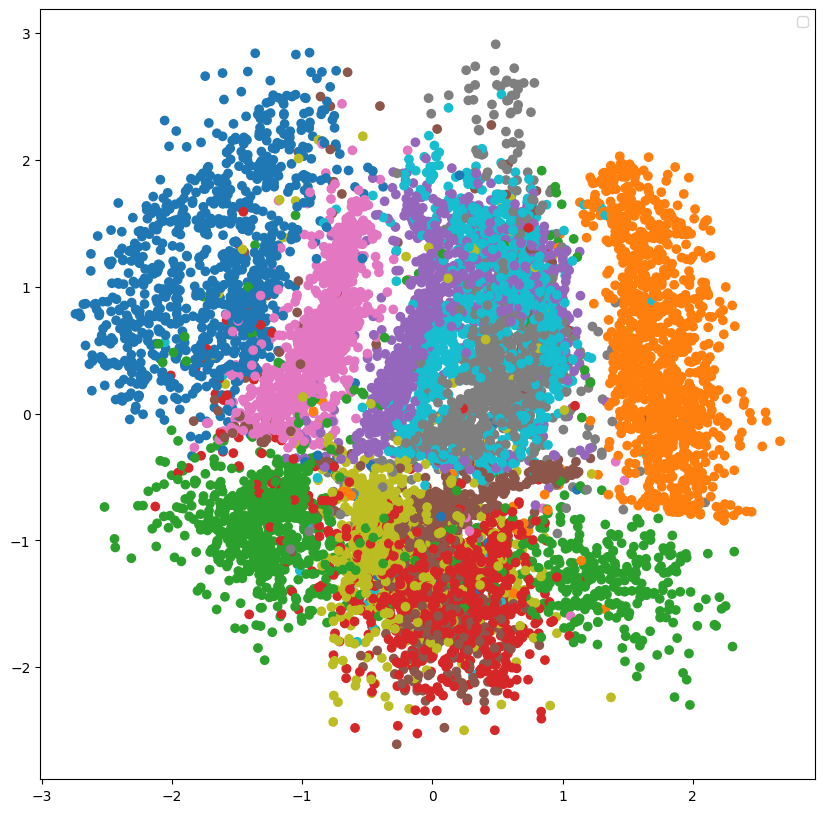

In [175]:
visualize_latent(M)

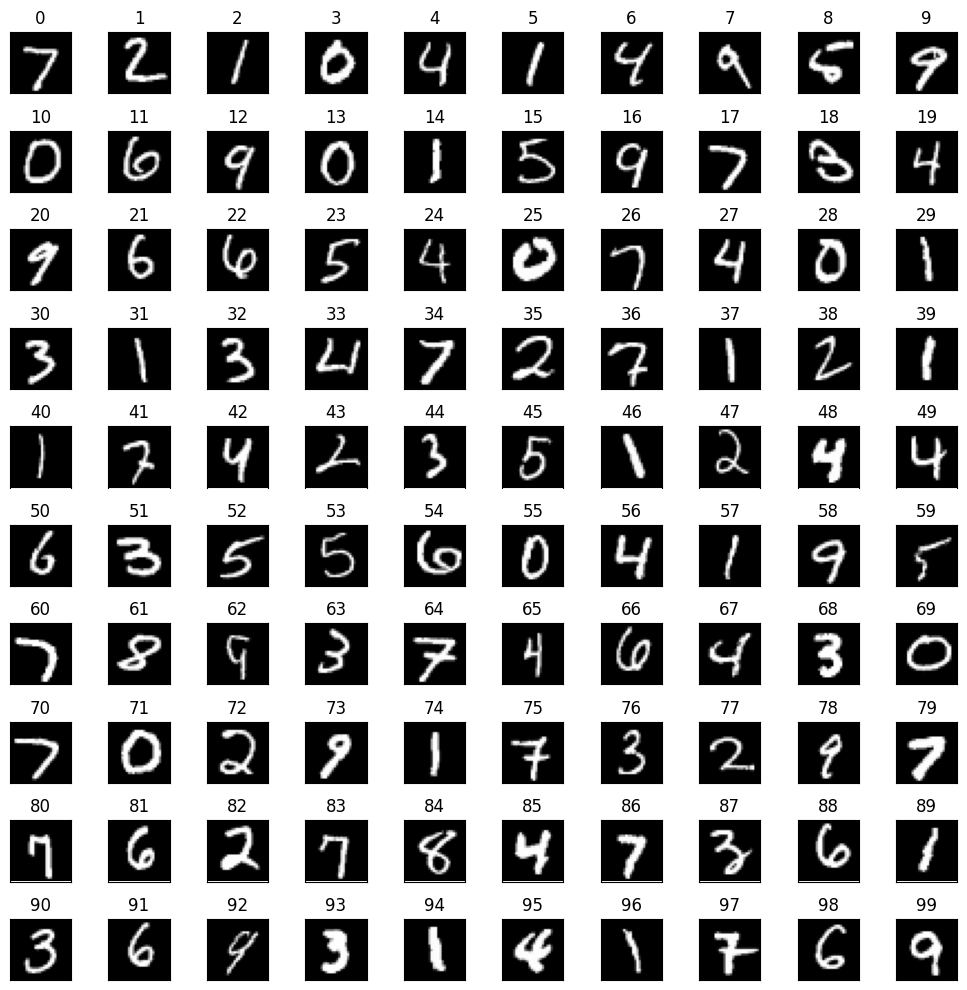

In [167]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
axs = axs.flatten()
data = testset.data.detach().numpy()[:100]
for i, d in enumerate(data):
    axs[i].imshow(d.reshape(28, 28), cmap='gray')
    axs[i].set_title(f'{i}')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()

/var/folders/nm/67sg27fj44j1q38vxt0_vzv80000gq/T/ipykernel_66096/4184314533.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


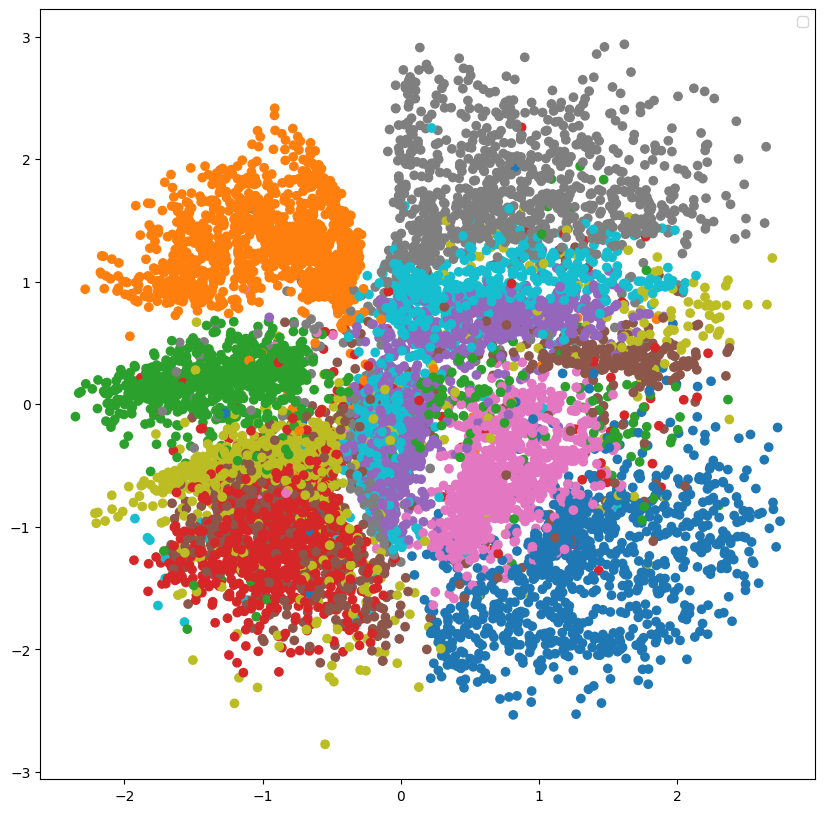

In [145]:
visualize_latent(M, )

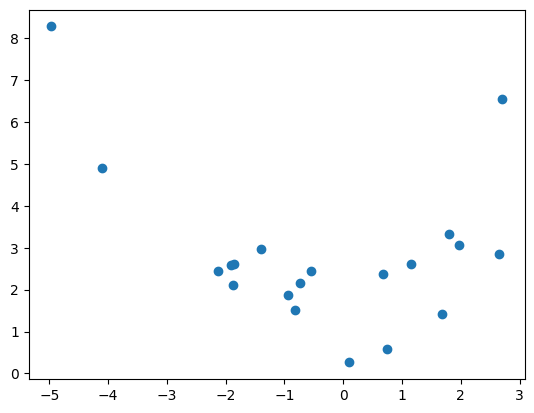

In [144]:
indices 
modeled = M(anchors.view(anchors.size(0), -1)).detach().numpy()
plt.scatter(modeled[:, 0], modeled[:, 1])

<Axes: >

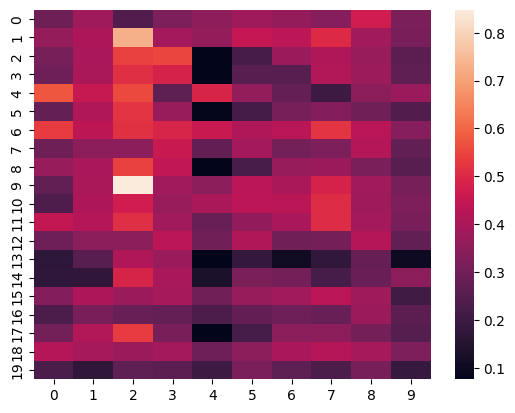

In [140]:
hmap_array = results[:, 2, :].T
seaborn.heatmap(hmap_array)

In [155]:
img = testset.data.detach().numpy()[0]
# plt.imshow(img.reshape(28, 28), cmap='gray')
plt.imshow(M(torch.tensor(img.reshape(784), dtype=torch.float32))
           .detach().numpy().reshape(28, 28),
           cmap='gray')

ValueError: expected 2D or 3D input (got 1D input)

Epoch: 0, Train Loss: 53.101568792015314
Epoch: 1, Train Loss: 43.77956510707736
Epoch: 2, Train Loss: 40.70944030955434
Epoch: 3, Train Loss: 39.308385234326124
Epoch: 4, Train Loss: 38.33128574118018
Epoch: 5, Train Loss: 37.734436489641666
Epoch: 6, Train Loss: 37.21895805001259
Epoch: 7, Train Loss: 36.8835282176733
Epoch: 8, Train Loss: 36.47259625419974
Epoch: 9, Train Loss: 36.26089333370328
Finished Training.
Epoch: 0, Train Loss: 52.40921584889293
Epoch: 1, Train Loss: 43.171339217573404
Epoch: 2, Train Loss: 40.8793754093349
Epoch: 3, Train Loss: 39.30313728749752
Epoch: 4, Train Loss: 38.408493019640446
Epoch: 5, Train Loss: 37.59876308590174
Epoch: 6, Train Loss: 37.30082086101174
Epoch: 7, Train Loss: 36.709921792149544
Epoch: 8, Train Loss: 36.30389736965299
Epoch: 9, Train Loss: 36.84480507299304
Epoch: 10, Train Loss: 36.07625463977456
Epoch: 11, Train Loss: 35.70844525285065
Epoch: 12, Train Loss: 35.48335906676948
Epoch: 13, Train Loss: 35.28748569637537
Epoch: 14, Tr

<Axes: >

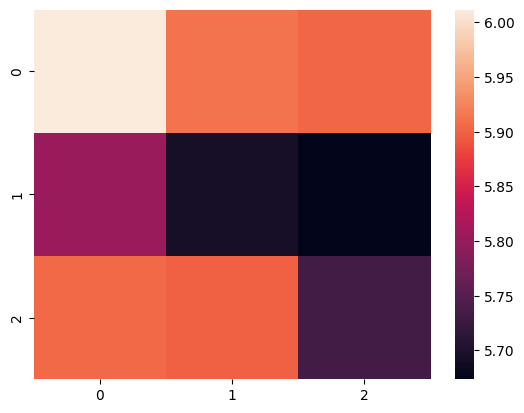

In [74]:
import seaborn

sizes = [100, 200, 300]
epochs = [10, 20, 30]
results = np.zeros((len(sizes), len(epochs)))
for i, s in enumerate(sizes):
    for j, e in enumerate(epochs):
        M = AutoEncoder(hidden_neurons=s)
        train_AE(M, epochs=e)
        results[i, j] = test_AE(M, to_print=False)

Epoch: 0, Train Loss: 12.39495948702097
Epoch: 1, Train Loss: 10.570389524102211
Epoch: 2, Train Loss: 10.25259118154645
Epoch: 3, Train Loss: 9.954996887594461
Epoch: 4, Train Loss: 9.735486190766096
Epoch: 5, Train Loss: 9.61851478740573
Epoch: 6, Train Loss: 9.551051661372185
Epoch: 7, Train Loss: 9.402587868273258
Epoch: 8, Train Loss: 9.285985250025988
Epoch: 9, Train Loss: 9.254503931850195
Epoch: 10, Train Loss: 9.180470433086157
Epoch: 11, Train Loss: 9.098478116095066
Epoch: 12, Train Loss: 9.118289966136217
Epoch: 13, Train Loss: 9.030216697603464
Epoch: 14, Train Loss: 9.01890093460679
Epoch: 15, Train Loss: 8.958474941551685
Epoch: 16, Train Loss: 8.980024978518486
Epoch: 17, Train Loss: 8.902380272746086
Epoch: 18, Train Loss: 8.832584422081709
Epoch: 19, Train Loss: 8.865940053015947
Epoch: 20, Train Loss: 8.91903916746378
Epoch: 21, Train Loss: 8.874728050082922
Epoch: 22, Train Loss: 8.958565808832645
Epoch: 23, Train Loss: 8.918373689055443
Epoch: 24, Train Loss: 8.812

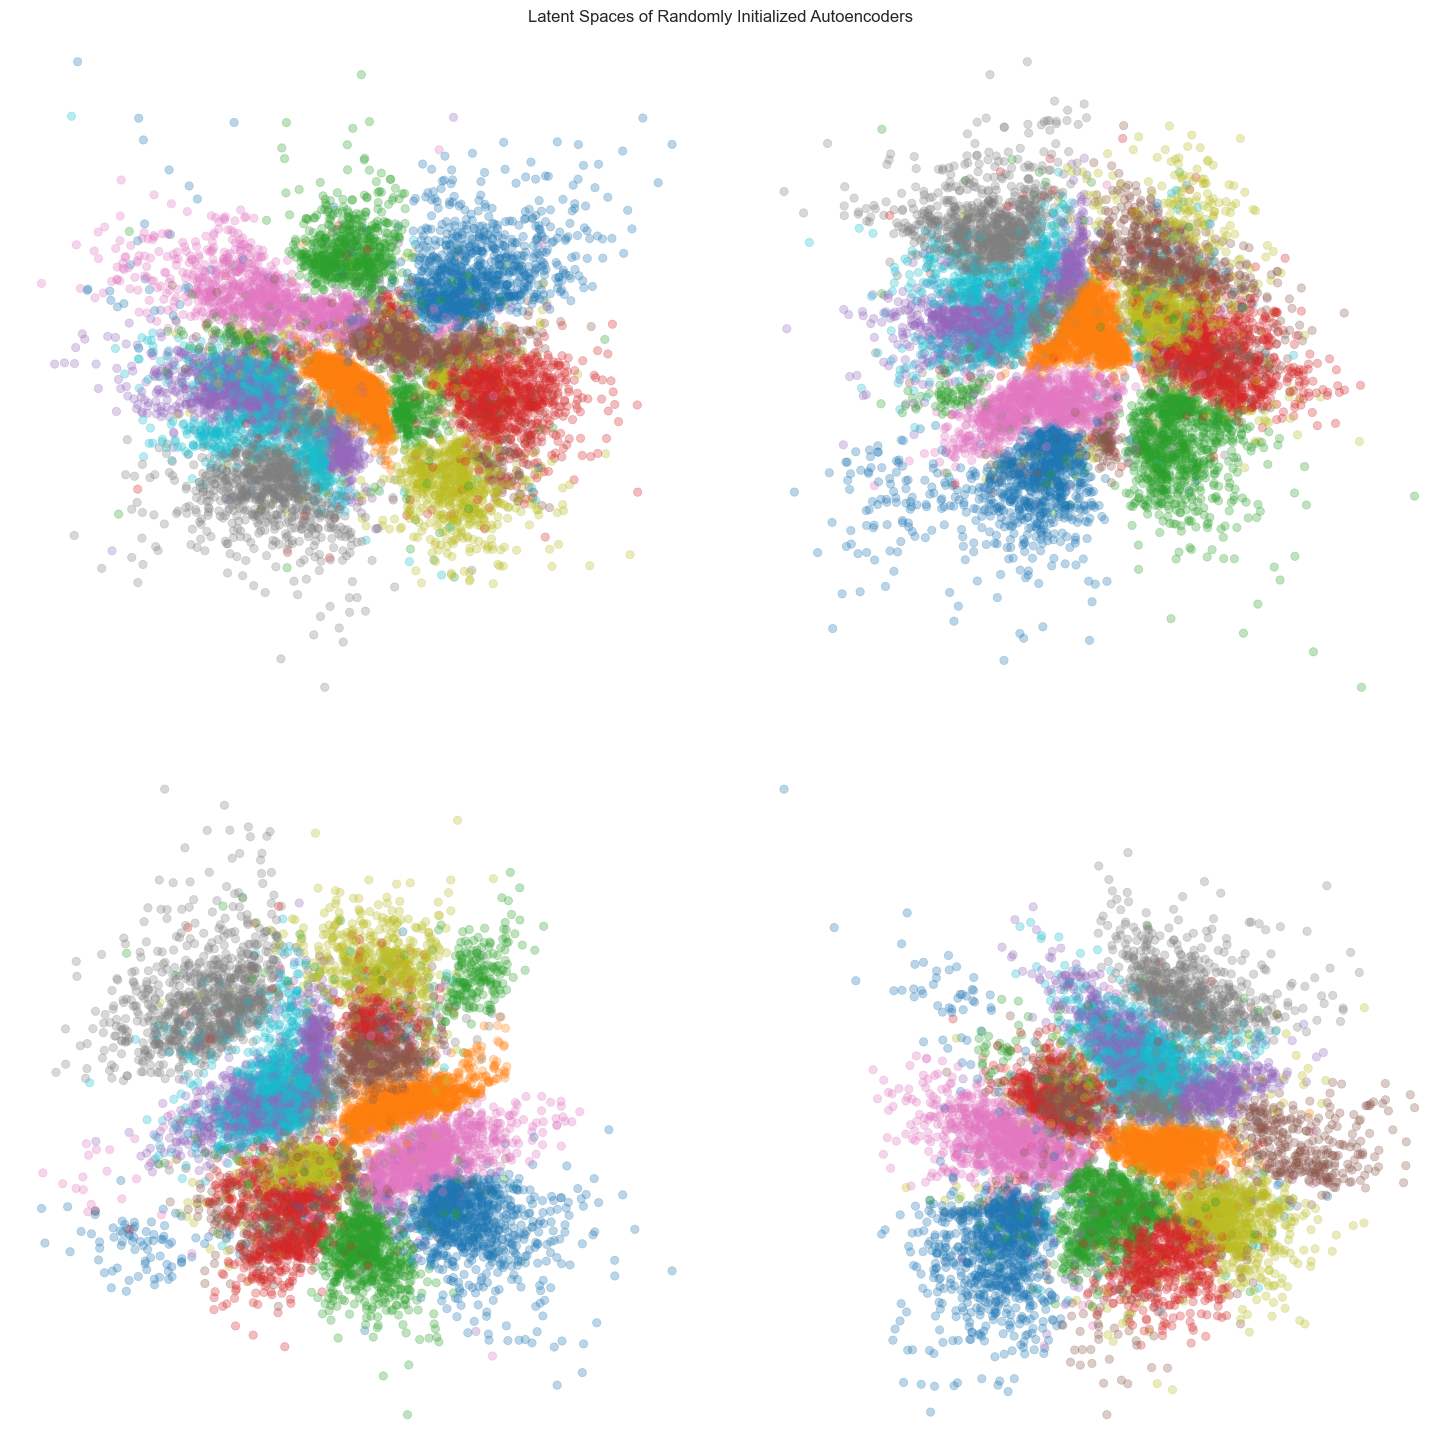

In [234]:
plt.style.use('ggplot')
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()
fig.suptitle('Latent Spaces of Randomly Initialized Autoencoders')
plt.tight_layout()
for i, ax in enumerate(axs):
    M = AutoEncoder(hidden_neurons=500)
    train_AE(M, epochs=60)
    latent_space = []
    labels = []
    for (input, label) in testloader:
        input = input.view(input.size(0), -1)
        output = M.encode(input)
        latent_space.append(output.detach().numpy())
        labels.append(label.detach().numpy())
    latent_space = np.concatenate(latent_space, axis = 0)
    labels = np.concatenate(labels, axis = 0)
    ax.scatter(latent_space[:, 0], latent_space[:, 1],
               c = labels, cmap = 'tab10', alpha=0.3)
    ax.set_axis_off()